In [1]:
!pip install ipynb
!pip install nbimporter
# Synthetic dataset
from sklearn.datasets import make_classification
# Data processing
import pandas as pd
import numpy as np
from collections import Counter
# Visualization
import matplotlib.pyplot as plt
# Model and performance
from sklearn.svm import OneClassSVM
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_curve, auc
import seaborn as sns
import plotly.express as px
sns.set(palette='rainbow', context='talk')
from sklearn.metrics import precision_recall_curve

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

import nbimporter
from ipynb.fs.full.EDA import vowelData
from ipynb.fs.full.EDA import irisData
from ipynb.fs.full.EDA import breastcancerData

In [2]:
frac_out = 0.2

### Functions

In [3]:
#Function to split inliers and outliers
def split_inandout(outlier,inlier,target, df_):
    df = df_.copy()
    class_label = target

    #Select the class you want to be outlier
    out_class = outlier
    outliers_samples = df[df.target == out_class]

    outliers_samples = outliers_samples.sample(frac = frac_out)

    #concat in out
    in_class = inlier
    inlier_samples = df[df.target == in_class]

    # Concatenate the modified outliers samples with the original inlier samples
    y = pd.concat([inlier_samples.target, outliers_samples.target], ignore_index=False).sort_index()
    x = pd.concat([inlier_samples.drop(columns=class_label), outliers_samples.drop(columns=class_label)], ignore_index=False).sort_index()

    return x,y

In [4]:
def split_TestTrain_normalize(x,y):
    # Train test split
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=43)

        # Check the number of records
    print('The number of records in the training dataset is', X_train.shape[0])
    print('The number of records in the test dataset is', X_test.shape[0])
    print(f"The training dataset has {sorted(Counter(y_train).items())[0][1]} records for the minority class and {sorted(Counter(y_train).items())[1][1]} records for the majority class.")
    
    # Assuming your dataset is a 2D array or a pandas DataFrame
    # Initialize the scaler
    scaler = StandardScaler()
    #scaler = MinMaxScaler()
    #scaler = RobustScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, X_test, y_train, y_test

In [5]:
def runAll_kernelsSVM(X_train,X_test,y_train,y_test, kernels,plot=False):
    classical_kernels = kernels
    ds1_f1 = []
    predictions = []
    predictionsTrains = []

    for kernel in classical_kernels:
        # Train the one class support vector machine (SVM) model
        one_class_svm = SVC( kernel = kernel).fit(X_train,y_train)
        
        # Predict the anomalies
        prediction_ = one_class_svm.predict(X_test)
        prediction = [0 if i==-1 else 1 for i in prediction_]
        print("{} kernel classification f1 score is {}".format(kernel,accuracy_score(y_test, prediction)))
        ds1_f1.append(f1_score(y_test, prediction))
        predictions.append(prediction)

        train_prediction = one_class_svm.predict(X_train)
        predictionTrain = [0 if i==-1 else 1 for i in train_prediction]
        predictionsTrains.append(predictionTrain)

        
    if (plot == True):
        # Set the width of the bars
        bar_width = 0.4

        # Create a list of x positions for the bars
        x_pos = range(len(classical_kernels))

        # Create the bar plot
        plt.bar(x_pos, ds1_f1, width=bar_width)

        # Set the x-axis labels
        plt.xticks(x_pos, classical_kernels)

        # Set the y-axis label
        plt.ylabel('F1 Score')

        # Set the title of the graph
        plt.title('F1 Score for Different Kernels (Iris Dataset)')

        # Add the rounded values on top of each bar
        for i, value in enumerate(ds1_f1):
            rounded_value = round(value, 3)  # Round off to three decimal points
            plt.text(i, value, str(rounded_value), ha='center', va='bottom')

        # Show the plot
        plt.show()
    return predictions,predictionsTrains

In [6]:
"""def plot_ROCCurve(y_test,y_score1):
    false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, y_score1)
    plt.subplots(1, figsize=(10,10))
    plt.title('Receiver Operating Characteristic - DecisionTree')
    plt.plot(false_positive_rate1, true_positive_rate1)
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()"""

'def plot_ROCCurve(y_test,y_score1):\n    false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, y_score1)\n    plt.subplots(1, figsize=(10,10))\n    plt.title(\'Receiver Operating Characteristic - DecisionTree\')\n    plt.plot(false_positive_rate1, true_positive_rate1)\n    plt.plot([0, 1], ls="--")\n    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")\n    plt.ylabel(\'True Positive Rate\')\n    plt.xlabel(\'False Positive Rate\')\n    plt.show()'

# IRIS DATASET

In [7]:
dataset_iris, x ,y = irisData ()
target = 'target'
print("The dataset selected has shape: " + str(dataset_iris.shape) + " and for each class "+ str(Counter(dataset_iris[target])))

The dataset selected has shape: (150, 5) and for each class Counter({0: 50, 1: 50, 2: 50})


## Apply OCC-SVM

### For multi-class datasets we need to select 1 target class and then set an smaller amount of outliers

In [8]:
out_class = 0
in_class = 1
x_,y_ = split_inandout(out_class,in_class,target,dataset_iris)
# Train test split
X_train, X_test, y_train, y_test = split_TestTrain_normalize(x_,y_)
Counter(y_)

The number of records in the training dataset is 48
The number of records in the test dataset is 12
The training dataset has 9 records for the minority class and 39 records for the majority class.


Counter({0: 10, 1: 50})

### Now we proceed with the OCC-SVM

In [9]:
kernels = ['rbf']
predictions,train_prediction = runAll_kernelsSVM(X_train, X_test,y_train, y_test,kernels)

print(classification_report(y_test, predictions[0]))

rbf kernel classification f1 score is 0.9166666666666666
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.92      1.00      0.96        11

    accuracy                           0.92        12
   macro avg       0.46      0.50      0.48        12
weighted avg       0.84      0.92      0.88        12



/Users/isabelmariaadrovercabot/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/isabelmariaadrovercabot/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/isabelmariaadrovercabot/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

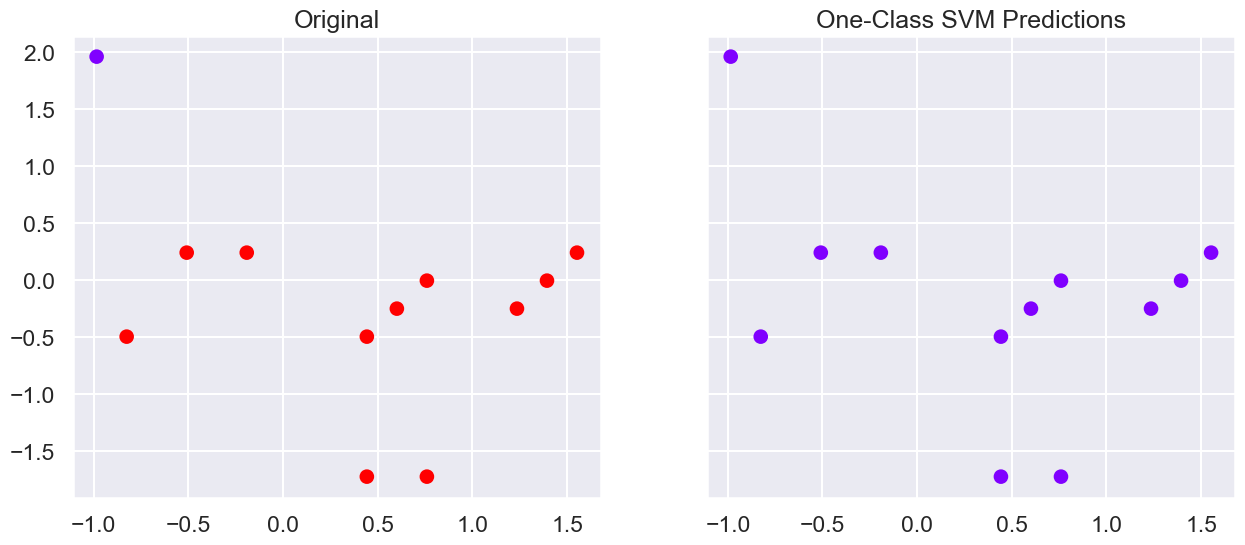

In [10]:
# Put the testing dataset and predictions in the same dataframe
X_test_ = X_test.copy()
y_test_ = y_test.copy()
df_test = pd.DataFrame(X_test_)
df_test['y_test'] = np.array(y_test_)
df_test['one_class_svm_prediction'] = predictions[0]
# Visualize the actual and predicted anomalies
fig, (ax0, ax1)=plt.subplots(1,2, sharey=True, figsize=(15,6))
# Ground truth
ax0.set_title('Original')
ax0.scatter(df_test[0], df_test[1], c=df_test['y_test'], cmap='rainbow')
# One-Class SVM Predictions
ax1.set_title('One-Class SVM Predictions')
ax1.scatter(df_test[0], df_test[1], c=df_test['one_class_svm_prediction'], cmap='rainbow')
plt.savefig('../figures/scatterplot_IRIS_SVM.png')

### Evaluation Metrics

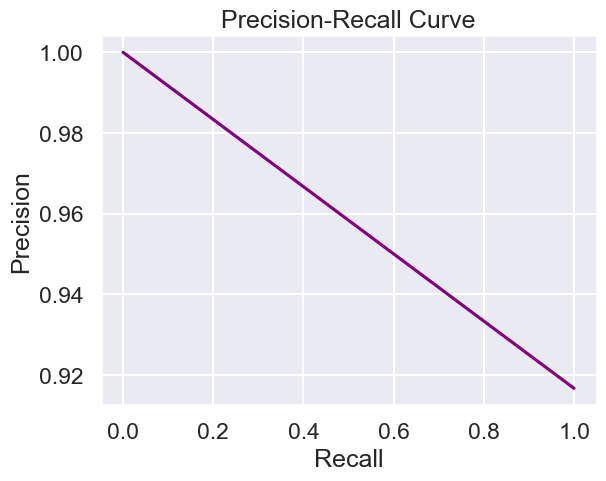

In [11]:
preds = predictions[0]
labels = y_test
#calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, preds)

#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
#plt.show()
plt.savefig('../figures/precisionCurve_IRIS_SVM.png')

### ROC-curve

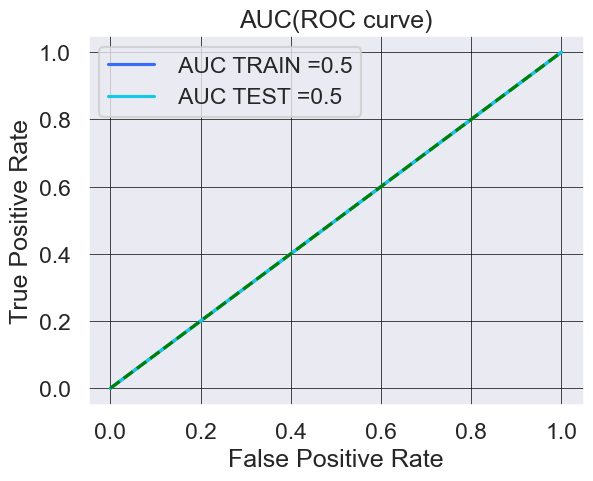

In [12]:
train_prediction = train_prediction[0]
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, train_prediction)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, predictions[0])

plt.grid()

plt.plot(train_fpr, train_tpr, label=" AUC TRAIN ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC(ROC curve)")
plt.grid(color='black', linestyle='-', linewidth=0.5)
#plt.show()
plt.savefig('../figures/ROCCurve_IRIS_SVM.png')

# VOWEL DATASET

In [13]:
vowelDataset, x ,y = vowelData ()
vowelDataset = vowelDataset.rename(columns={'feature12':'target'})
#for vowels dataset
target = 'target'

print("The dataset selected has shape: " + str(vowelDataset.shape) + " and for each class "+ str(Counter(vowelDataset[target])))

The dataset selected has shape: (990, 13) and for each class Counter({0: 90, 1: 90, 2: 90, 3: 90, 4: 90, 5: 90, 6: 90, 7: 90, 8: 90, 9: 90, 10: 90})


## Apply OCC-SVM

### For multi-class datasets we need to select 1 target class and then set an smaller amount of outliers

In [14]:
out_class = 0
in_class = 1
x,y = split_inandout(out_class,in_class,target,vowelDataset)
# Train test split
X_train, X_test, y_train, y_test = split_TestTrain_normalize(x,y)
Counter(y)

The number of records in the training dataset is 86
The number of records in the test dataset is 22
The training dataset has 16 records for the minority class and 70 records for the majority class.


Counter({1: 90, 0: 18})

### Now we proceed with the OCC-SVM

In [15]:
kernels = ['rbf']
predictions,train_prediction = runAll_kernelsSVM(X_train, X_test,y_train, y_test,kernels)

print(classification_report(y_test, predictions[0]))

rbf kernel classification f1 score is 0.9090909090909091
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.91      1.00      0.95        20

    accuracy                           0.91        22
   macro avg       0.45      0.50      0.48        22
weighted avg       0.83      0.91      0.87        22



/Users/isabelmariaadrovercabot/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/isabelmariaadrovercabot/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/isabelmariaadrovercabot/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

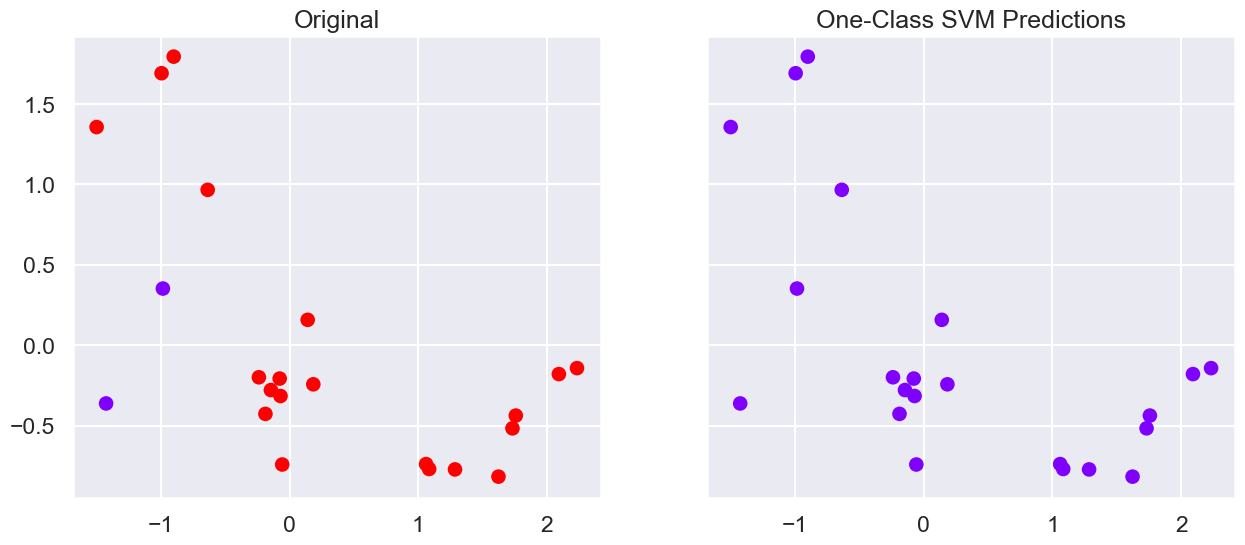

In [16]:
# Put the testing dataset and predictions in the same dataframe
X_test_ = X_test.copy()
y_test_ = y_test.copy()
df_test = pd.DataFrame(X_test_)
df_test['y_test'] = np.array(y_test_)
df_test['one_class_svm_prediction'] = predictions[0]
# Visualize the actual and predicted anomalies
fig, (ax0, ax1)=plt.subplots(1,2, sharey=True, figsize=(15,6))
# Ground truth
ax0.set_title('Original')
ax0.scatter(df_test[2], df_test[3], c=df_test['y_test'], cmap='rainbow')
# One-Class SVM Predictions
ax1.set_title('One-Class SVM Predictions')
ax1.scatter(df_test[2], df_test[3], c=df_test['one_class_svm_prediction'], cmap='rainbow')
plt.savefig('../figures/ScatterPlot_VOWEL_SVM.png')

### Evaluation Metrics

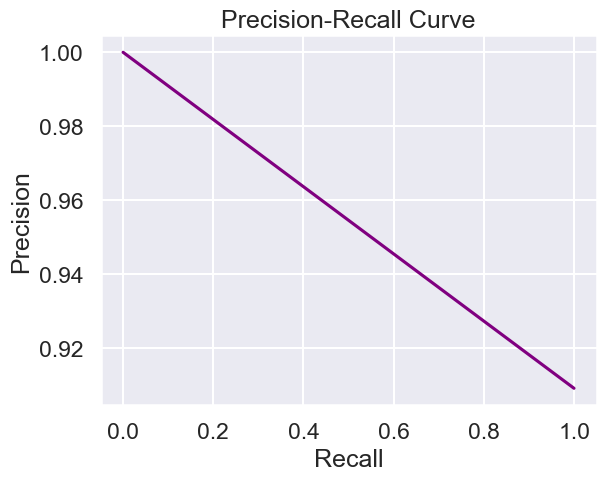

In [17]:
preds = predictions[0]
labels = y_test
#calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, preds)

#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
#plt.show()
plt.savefig('../figures/PrecisionCurve_VOWEL_SVM.png')

### ROC-curve

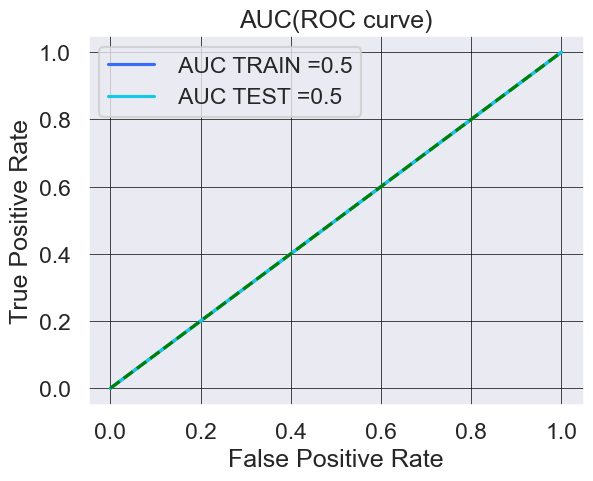

In [18]:
train_prediction = train_prediction[0]
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, train_prediction)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, predictions[0])

plt.grid()

plt.plot(train_fpr, train_tpr, label=" AUC TRAIN ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC(ROC curve)")
plt.grid(color='black', linestyle='-', linewidth=0.5)
#plt.show()
plt.savefig('../figures/RocCurve_VOWEL_SVM.png')

# BREAST CANCER DATASET

In [19]:
breast_dataset, x ,y = breastcancerData()
target = 'target'

print("The dataset selected has shape: " + str(breast_dataset.shape) + " and for each class "+ str(Counter(breast_dataset[target])))

The dataset selected has shape: (569, 31) and for each class Counter({1: 357, 0: 212})


## Apply OCC-SVM

### For multi-class datasets we need to select 1 target class and then set an smaller amount of outliers

In [20]:
out_class = 0
in_class = 1
x_,y_ = split_inandout(out_class,in_class,target,breast_dataset)
# Train test split
X_train, X_test, y_train, y_test = split_TestTrain_normalize(x_,y_)
Counter(y_)

The number of records in the training dataset is 319
The number of records in the test dataset is 80
The training dataset has 32 records for the minority class and 287 records for the majority class.


Counter({0: 42, 1: 357})

### Now we proceed with the OCC-SVM

In [21]:
kernels = ['rbf']
predictions,train_prediction = runAll_kernelsSVM(X_train, X_test,y_train, y_test,kernels)

print(classification_report(y_test, predictions[0]))

rbf kernel classification f1 score is 0.875
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.88      1.00      0.93        70

    accuracy                           0.88        80
   macro avg       0.44      0.50      0.47        80
weighted avg       0.77      0.88      0.82        80



/Users/isabelmariaadrovercabot/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/isabelmariaadrovercabot/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/isabelmariaadrovercabot/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

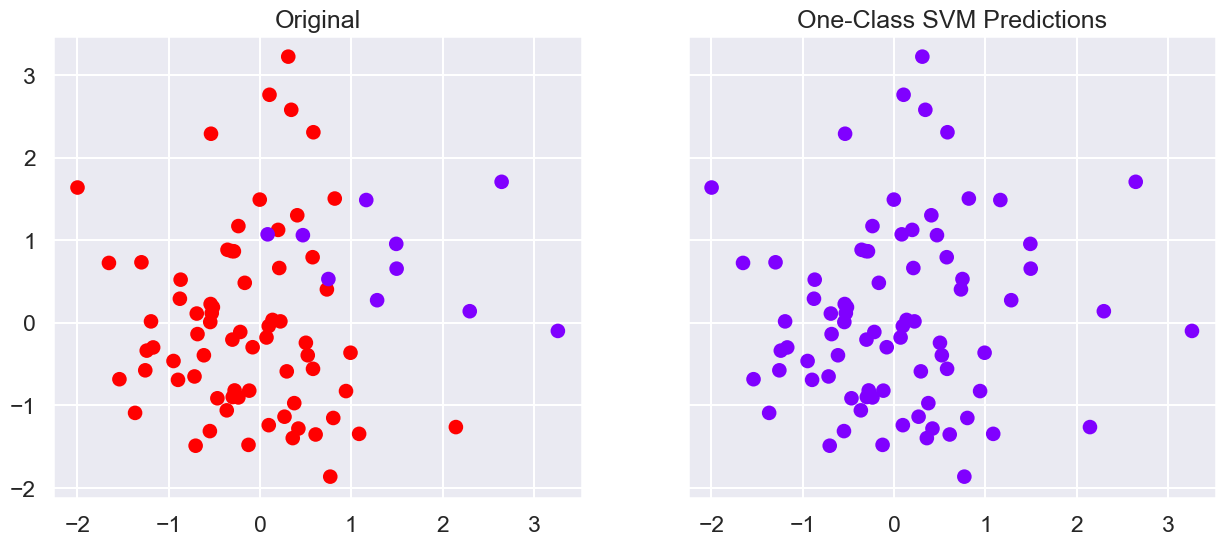

In [22]:
# Put the testing dataset and predictions in the same dataframe
X_test_ = X_test.copy()
y_test_ = y_test.copy()
df_test = pd.DataFrame(X_test_)
df_test['y_test'] = np.array(y_test_)
df_test['one_class_svm_prediction'] = predictions[0]
# Visualize the actual and predicted anomalies
fig, (ax0, ax1)=plt.subplots(1,2, sharey=True, figsize=(15,6))
# Ground truth
ax0.set_title('Original')
ax0.scatter(df_test[0], df_test[1], c=df_test['y_test'], cmap='rainbow')
# One-Class SVM Predictions
ax1.set_title('One-Class SVM Predictions')
ax1.scatter(df_test[0], df_test[1], c=df_test['one_class_svm_prediction'], cmap='rainbow')
plt.savefig('../figures/Scatterplot_BREAST_SVM.png')

### Evaluation Metrics

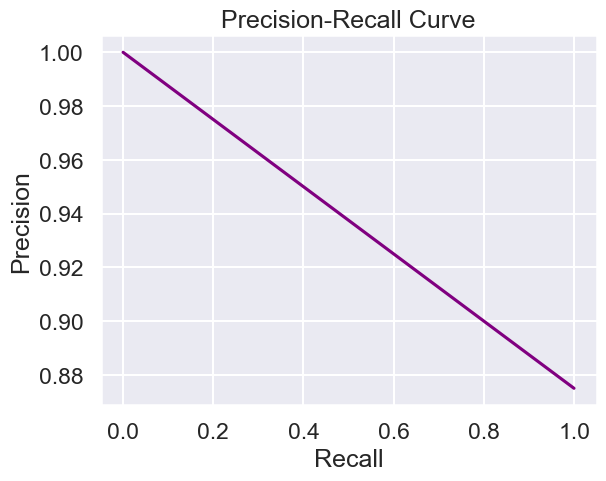

In [23]:
preds = predictions[0]
labels = y_test
#calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, preds)

#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
#plt.show()
plt.savefig('../figures/PrecisionCurve_BREAST_SVM.png')

### ROC-curve

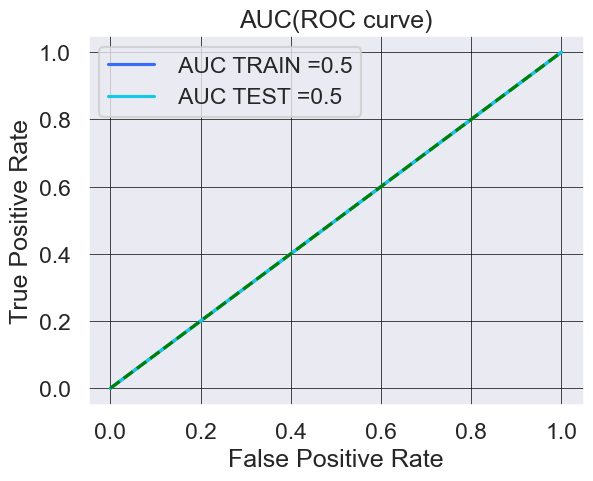

In [24]:
train_prediction = train_prediction[0]
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, train_prediction)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, preds)

plt.grid()

plt.plot(train_fpr, train_tpr, label=" AUC TRAIN ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC(ROC curve)")
plt.grid(color='black', linestyle='-', linewidth=0.5)
#plt.show()
plt.savefig('../figures/ROCCurve_BREAST_SVM.png')